In [37]:
%%HTML
<style>
  @import url('https://fonts.googleapis.com/css2?family=JetBrains+Mono&display=swap');

  body {
    font-family: 'JetBrains Mono', -apple-system, BlinkMacSystemFont, 'Segoe WPC', 'Segoe UI', system-ui, 'Ubuntu', 'Droid Sans', sans-serif;
    line-height: 1.67;
  }
</style>

In [67]:
# Import modules for HTML display in the notebook and enable inline mode for Matplotlib
from IPython.display import display, HTML, Math, Latex
from IPython.core.magic import register_cell_magic
  
%matplotlib inline

# Import common libraries for data manipulation, optimization, and control
import pandas as pd  # type: ignore
import cvxpy as cp  # type: ignore
from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import matplotlib as mpl  # type: ignore
from matplotlib.patches import FancyArrowPatch # type: ignore
from scipy.integrate import quad # type: ignore
import importlib
import itertools
import csv
import concurrent.futures
from scipy.spatial import ConvexHull
import os, math, sys
import json
from scipy.interpolate import interp1d
import numpy as np
import json
from typing import Dict, List, Any, Optional, Literal


from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

base_path = os.path.abspath("..")  # pasta acima do notebook/script

dirs_to_add = ["Utils", "Optimization Problems", "DisturbedSaturatedPETC"]
for d in dirs_to_add:
    path = os.path.join(base_path, d)
    if path not in sys.path:
        sys.path.append(path)
        
import Tex as tex
import Graphs as gph
import Signal as sgn
import Numeric as nm
import DynamicSystem as ds
import DisturbedSaturatedPETC as DSPETC

importlib.reload(tex)
importlib.reload(gph)
importlib.reload(sgn)
importlib.reload(nm)
importlib.reload(ds)
importlib.reload(DSPETC)

# Attempt to configure LaTeX for text rendering, otherwise use default Matplotlib fonts
gph.use_latex()

# Set the resolution of figures generated by Matplotlib
mpl.rcParams['figure.dpi'] = 100

cfg = {
    'style': {'color': 'black'},
    'axis': {
        'title_pad': 10,
        'y_digits': 2,
        'x_digits': 2,
        'x_label_fontsize': 16,
        'y_label_fontsize': 16,
        'tick_fontsize': 16,
    },
}

@register_cell_magic
def skip(line, cell):
  return

LaTeX has been enabled for text rendering.


### Definição da Planta

In [39]:
experiment_config_filename = 'experiment-1'

with open(f"experiment_configs/{experiment_config_filename}.json", encoding='utf-8') as f:
  config = json.load(f)

sim_duration = config['simulation_duration']
sim_step = config.get("simulation_step", 1e-4)
timepts = np.arange(0, sim_duration + sim_step, sim_step)

plant = ds.StateSpace(data=config["plant"])
# for matrix in ["A", "B", "E"]:
#   plant.display_matrix(matrix)

### Simulação da Planta em Malha Aberta

In [40]:
ncs = ds.NetworkedControlSystem()
ncs.add_system(plant, 'plant')

x0 = np.array([[1.0], [-1.0]], dtype=np.float32)
ncs.get_system('plant').set_initial_state(x0)

ncs.setup_clock(duration=20.0, dt=1e-4)
ncs.reset_clock()

while ncs.advance_clock():
  inputs = {'plant': {'u1': 0}}
  ncs.update_systems(inputs)

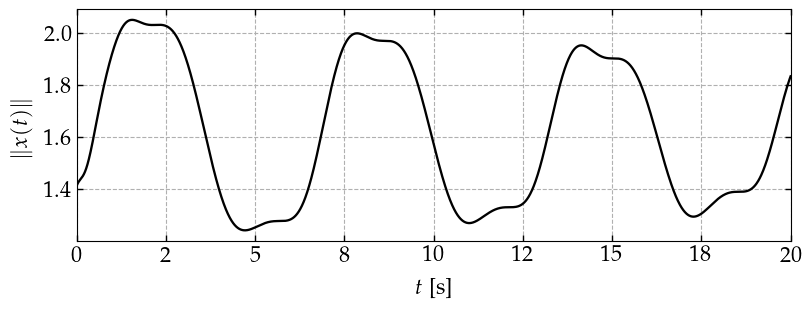

In [41]:
# Plotagem dos resultados
fig = plt.figure(figsize=(8, 3), layout='constrained')
axs = fig.subplot_mosaic([["x"]])

y = ncs.output_history['plant']  # shape (ny, n_steps)
t = ncs.time_history

# Calcula norma ao longo das saídas
x_norm = np.linalg.norm(y, axis=0)  # shape (n_steps,)

# Formata para plot
xnorm_f, xnorm_ul, xnorm_dp = nm.format_magnitudes(x_norm,  n_divs=5)
t_f, t_ul, t_dp = nm.format_magnitudes(t, 's', use_prefixes=True, n_divs=5)
axis_limits = {'x_min': 0., 'x_max': t_f[-1]}

gph.plot(
    axs['x'], t_f, x_norm,
    xlabel='$t$' + t_ul,
    ylabel=r'$\|x(t)\|$',
    plot_cfg={**cfg,
              'axis': {**cfg['axis'],
                       'x_digits': t_dp,
                       'y_digits': xnorm_dp},
              'limits': axis_limits,
              }
)

### Projeto do Controlador e do ETM

In [ ]:
def get_C(rho_values):
  return np.array([[1.0, 0.0]], dtype=np.float32)

plant_data = {
    'nx': plant.nx,
    'nu': plant.nu,
    'nρ': plant.nρ,
    'nw': plant.nw,
    'ρ_bounds': [(-0.5, 0.5)],
    'u_bar': [.5],
    'matrices_func': lambda ρi: plant.matrices_func(ρi),
    'get_C': get_C
}

h, υ, ε_γ, δ, λ = 1e-3, 1e-1, 1e-1, 10, 1e-1
θ = (1. / λ) * (np.exp(λ * h) - 1) + 1

# --- Parâmetros de projeto ---
design_params = {'h': h, 'υ': υ, 'δ': δ, 'ε_γ': ε_γ, 'λ': λ, 'θ': θ}

# --- Executar o solver ---
results = DSPETC.DETM(plant_data, design_params)

Ξ = Ψ = K = L1 = P = γ = β = None
Θ, λ = None, None
optimal_value = None
δinv = 1e-1

if results is not None:
  Ξ, Ψ = results['etm']['Ξ'], results['etm']['Ψ']
  θ, λ = results['etm']['θ'], results['etm']['λ']
  K, L1, L2 = results['controller']['K'], results['controller']['L1'], \
      results['controller']['L2']
  P, S2 = results['lyapunov']
  γ, β = results['bounds']
  optimal_value = results['optimal_value']

  # print(f'β = {β:.3e}')
  # print(f'x.T P x <= {1./β:.3e}')
  print(f'θ = {θ:.3e}')
  print(f'λ = {λ:.3e}')
  print(f'γ = {γ:.3e}')
  print(f'Induced gain = {(np.sqrt(1. / γ)):.3e}')

  display(Math(rf'\Xi = {tex.mat2tex(Ξ)}'))
  display(Math(rf'\Psi = {tex.mat2tex(Ψ)}'))

  display(Math(rf'P = {tex.mat2tex(P)}'))

  for i in nm.binary_set(plant.nρ):
    display(Math(rf'K_{{{i}}} = {tex.mat2tex(K[i])}'))
    display(Math(rf'L_{{{i}}} = {tex.mat2tex(L1[i])}'))
else:
  print('Problema não é factível!')

θ = 1.001e+00
λ = 1.000e-01
γ = 1.000e-01
Induced gain = 3.162e+00


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
# Definição inicial das variáveis
Ξ = Ψ = K = L1 = P = γ = β = None
Θ, λ = None, None
optimal_value = None
δinv = 1e-1

# Parâmetros e resolução do problema
h, υ, ε_γ, δ, λ = 1e-3, 1e-1, 1e-1, 1. / δinv, 1e-1
θ = (1. / λ) * (np.exp(λ * h) - 1) + 1
prob_res = solve_problem(h=h, υ=υ, δ=δ, ε_γ=ε_γ, λ=λ, θ=θ, eps=1e-5)

if prob_res is not None:
  Ξ, Ψ = prob_res['etm']['Ξ'], prob_res['etm']['Ψ']
  θ, λ = prob_res['etm']['θ'], prob_res['etm']['λ']
  K, L1, L2 = prob_res['controller']['K'], prob_res['controller']['L1'], \
      prob_res['controller']['L2']
  P, S2 = prob_res['lyapunov']
  γ, β = prob_res['bounds']
  optimal_value = prob_res['optimal_value']

  # print(f'β = {β:.3e}')
  # print(f'x.T P x <= {1./β:.3e}')
  print(f'θ = {θ:.3e}')
  print(f'λ = {λ:.3e}')
  print(f'γ = {γ:.3e}')
  print(f'Induced gain = {(np.sqrt(1. / γ)):.3e}')

  display(Math(rf'\Xi = {tex.mat2tex(Ξ)}'))
  display(Math(rf'\Psi = {tex.mat2tex(Ψ)}'))

  display(Math(rf'P = {tex.mat2tex(P)}'))

  for i in nm.binary_set(sys.nρ):
    display(Math(rf'K_{{{i}}} = {tex.mat2tex(K[i])}'))
    display(Math(rf'L_{{{i}}} = {tex.mat2tex(L1[i])}'))
else:
  print('Problema não é factível!')

AttributeError: 'StateSpace' object has no attribute 'get_rho_bounds'

In [ ]:
eps_γ_values = np.logspace(-6, -1, num=1000)

# Função a ser executada em paralelo


def run_solver(eps_γ):
  try:
    prob_res = solve_problem(h=h, υ=υ, δ=δ, ε_γ=eps_γ, λ=λ, θ=θ, eps=1e-5)
    if prob_res is not None:
      γ, β = prob_res['bounds']
      optimal_value = prob_res['optimal_value'] - β
      return γ, β, optimal_value
  except Exception as e:
    print(f'Erro para ε_γ = {eps_γ:.1e}: {e}')
  return None


# Execução paralela com processos
results = []
with concurrent.futures.ProcessPoolExecutor() as executor:
  futures = {executor.submit(run_solver, eps): eps for eps in eps_γ_values}
  for future in concurrent.futures.as_completed(futures):
    result = future.result()
    if result is not None:
      results.append(result)

# Organiza os resultados por γ
results = sorted(results, key=lambda x: x[0])
γ_vals = np.array([r[0] for r in results])
β_vals = np.array([r[1] for r in results])
traces = np.array([r[2] for r in results])

In [ ]:
data_to_save = {
    "gamma_vals": γ_vals.tolist(),
    "traces": traces.tolist(),
    "beta_vals": β_vals.tolist()
}

# Salva em arquivo JSON
with open("Results/Notebook-I/ClosedLoop_Results_OptProb.json", "w") as f:
  json.dump(data_to_save, f, indent=2)

In [ ]:
%matplotlib inline

# Define configurações globais de fonte
plt.rcParams.update({
    'font.size': 14,       # Tamanho de fonte global
    'axes.labelsize': 14,  # Tamanho dos rótulos dos eixos
    'xtick.labelsize': 14,  # Tamanho dos ticks no eixo x
    'ytick.labelsize': 14,  # Tamanho dos ticks no eixo y
})

# Layout lado a lado
mosaic = [['tr', 'β']]
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8, 4))

# Gráfico 1: tr(Ψ + Ξ) vs γ
axs['tr'].plot(γ_vals, traces, marker='o', color='black')
axs['tr'].set_xscale('log')
axs['tr'].set_xlabel(r'$\gamma$')
axs['tr'].set_ylabel(r'tr($\tilde \Psi + \tilde \Xi$)')
axs['tr'].grid(True)

# Gráfico 2: β vs γ
axs['β'].plot(γ_vals, β_vals, marker='s', color='black')
axs['β'].set_xscale('log')
axs['β'].set_xlabel(r'$\gamma$')
axs['β'].set_ylabel(r'$\beta$')
axs['β'].grid(True)

# Ajuste final e exibição
plt.tight_layout()
plt.show()

In [ ]:
# Definindo intervalo de plotagem
x1_range = (-0.5, 0.5)
x2_range = (-0.5, 0.5)
num_points = 20

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(6., 6.))

# a_q = nm.get_vertices(x_bounds)

B2 = nm.binary_set(sys.nρ)
u_bar = sys.get_u_bar()

x_vals = np.linspace(x1_range[0], x1_range[1], int(1e3))
y_vals = np.linspace(x2_range[0], x2_range[1], int(1e3))


X, y = np.meshgrid(x_vals, y_vals)
points = np.vstack([X.ravel(), y.ravel()]).T
Du_region = np.ones(X.shape, dtype=bool)
for b in B2:
  result = np.abs(points @ (K[b] - L1[b]).T)
  # result = np.abs(points @ (K[b]).T)
  Du_region &= (result.reshape(X.shape) <= u_bar[0])
ax.contour(X, y, Du_region, colors='#084475', linewidths=1.5)

Du_tilde_region = np.ones(X.shape, dtype=bool)
for b in B2:
    result = np.abs(points @ (K[b]).T)
    Du_tilde_region &= (result.reshape(X.shape) <= u_bar[0])
saturation_region = ~Du_tilde_region

ax.contourf(X, y, saturation_region, levels=[0.4, 1.5], colors=['#d0d0d0'], linewidths=0)

X0_list = nm.ellipsoid_boundary_points(P, 1, num_points)
plt.plot(X0_list[0], X0_list[1], '*',
         linestyle='None', c='black', markersize=12)
X0_list = np.hstack((np.array([[-0.20346692],  [0.33822176]]), X0_list))

D0 = nm.get_ellipsoid_boundary(P, 1)
plt.plot(D0['x1_vals'], D0['x2_vals'], 
         'k-', label='')

μ_inv = 1. + (1. / (γ * δ))
Dx = nm.get_ellipsoid_boundary(P, μ_inv)
plt.plot(Dx['x1_vals'], Dx['x2_vals'], 
         'k--', label='')

# Ajustes finais de layout
ax.set_xlabel("$x_1$", fontsize=20)
ax.set_ylabel("$x_2$", fontsize=20)
ax.tick_params(axis='both', labelsize=16)

ax.grid(True)

# Legendas
elements = [
    ('line', {'color': '#084475', 'linestyle': '-', 'linewidth': 2.0}),
    ('line', {'color': 'black', 'linestyle': '--', 'linewidth': 2.}),
    ('line', {'color': 'black', 'linestyle': '-', 'linewidth': 2.}),
    ('line', {'color': 'black', 'linestyle': ':', 'linewidth': 2.}),
    ('marker', {'marker': '*', 'color': 'black', 'markersize': 10})
]

labels = [r'$\mathscr{D}_u$', r'$\mathscr{D}_x$', r'$\mathscr{D}_0$', 
          'Traj.', 'P. I.']

gph.create_custom_legend(ax, elements, labels)

# Exibir o gráfico
plt.tight_layout()

In [ ]:
def closedloop_simulation(x0, η0, λ, θ, T_s):

  N = len(timepts)
  nx = x0.shape[0]

  x = np.zeros((nx, N + 1, 1))
  η = np.zeros((N + 1, 1))

  x[:, 0, :] = x0
  η[0, :] = η0

  xτ = x0.copy()

  y = []
  uc = []

  ρ_hat = np.array(sys.evaluate_parameters(0)).reshape(-1, 1)
  x_hat = x0
  event_times = [0.]

  next_time_sampling = h

  def triggering_condition(η, x, ε):
    Tcal = x.T @ Ψ @ x - ε.T @ Ξ @ ε
    if η <= 1e-4:
      η = 0
    new_event = η + θ * Tcal[0][0] < -1e-4
    return new_event

  def etm_dynamics(t, η, u, params):
    ε = x_hat - xτ
    Tcal = xτ.T @ Ψ @ xτ - ε.T @ Ξ @ ε
    η_dot = - λ * η + Tcal[0][0]
    return η_dot

  def control_signal():
    ρ_bounds = sys.get_rho_bounds()
    u_bar = sys.get_u_bar()
    α0 = (ρ_bounds[0][1] - ρ_hat) / (ρ_bounds[0][1] - ρ_bounds[0][0])
    uc_k = α0 * K[(0,)] @ x_hat + (1. - α0) * K[(1,)] @ x_hat
    return np.array([[sgn.sat(uc_k[0, 0], u_bar[0])]])

  for k, t in enumerate(timepts):

    ρ = np.array(sys.evaluate_parameters(t)).reshape(-1, 1)
    w = np.array(sys.evaluate_disturbances(t)).reshape(-1, 1)

    # Verificação da condição de acionamento
    if t >= next_time_sampling:
      next_time_sampling += h
      xτ = x[:, k, :]
      ε = x_hat - xτ
      new_event = triggering_condition(η[k], xτ, ε)
      if new_event:
        # print('True')
        ρ_hat = ρ
        x_hat = xτ
        event_times.append(t)

    # Cálculo do sinal de controle
    u_sat = control_signal()
    inputs_vec = np.hstack((u_sat, ρ, w))[0]

    # Saída da planta
    y.append(plant_output(t, x[:, k, :], inputs_vec, ρ))

    # Atualização dos estados para o próximo passo (k+1)
    if k < N - 1:
      x[:, k + 1, :] = nm.rk5_step(
          lambda t_, x_, inputs_, p: plant_dynamics(t_, x_, inputs_, sys),
          t, x[:, k, :], inputs_vec, T_s, ρ)
      η[k + 1, :] = nm.rk5_step(etm_dynamics, t, η[k, :], None, T_s, None)

    # Armazena controle e saída em k
    uc.append(u_sat)
  return y, uc, η[:N], event_times

In [ ]:
# Nome do arquivo de experimento
experiment_name = "Results/Notebook-I/ClosedLoop_Results_Abdullah2009.json"
force_simulation = False
simulations_amount = 21

# Estrutura para armazenar os resultadosevent_times
results_clsim = {
    'inter-event-times': [],
    'control-signal': [],
    'trajectories': [],
    'eta': [],
}

# Função para converter arrays e listas aninhadas em estruturas serializáveis


def convert_to_serializable(obj):
  if isinstance(obj, np.ndarray):
    return obj.tolist()
  elif isinstance(obj, list):
    return [convert_to_serializable(item) for item in obj]
  elif isinstance(obj, dict):
    return {key: convert_to_serializable(val) for key, val in obj.items()}
  return obj

# Função para converter de volta para arrays


def convert_to_numpy(obj):
  return {
      'trajectories': [np.array(y_k) for y_k in obj['trajectories']],
      'control-signal': [np.array(u_k) for u_k in obj['control-signal']],
      'eta': [np.array(eta_k) for eta_k in obj['eta']],
      'inter-event-times': obj['inter-event-times'],
  }


# Verificar se o arquivo já existe
if os.path.exists(experiment_name) and not force_simulation:
  print(f"O arquivo {experiment_name} já existe. Carregando dados salvos.")
  with open(experiment_name, "r") as f:
    loaded = json.load(f)
    results_clsim = convert_to_numpy(loaded)
else:
  def get_trajectories(i):
    x0 = np.array([[X0_list[0][i]], [X0_list[1][i]]])
    η0 = np.array([[0.]])

    y, uc, η, event_times = closedloop_simulation(
        x0, η0, λ, θ, T_s=sim_step)
    inter_event_times = np.diff(event_times).tolist()

    return {
        'trajectories': y,
        'eta': η,
        'control-signal': uc,
        'inter-event-times': inter_event_times
    }

  # Paralelismo com ProcessPoolExecutor
  with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(get_trajectories,
                                range(simulations_amount)))

  # Atualizar estrutura de resultados
  for res in results:
    results_clsim['trajectories'].append(res['trajectories'])
    results_clsim['inter-event-times'].append(res['inter-event-times'])
    results_clsim['control-signal'].append(res['control-signal'])
    results_clsim['eta'].append(res['eta'])

  # Serializar e salvar
  results_serializable = convert_to_serializable(results_clsim)

  with open(experiment_name, "w") as f:
    json.dump(results_serializable, f, indent=2)

  print(f"Simulações concluídas. Resultados salvos em {experiment_name}.")

In [ ]:
%matplotlib inline

simulation_index = 11
inter_event_times = results_clsim['inter-event-times'][simulation_index]
uc = results_clsim['control-signal'][simulation_index]
y = results_clsim['trajectories'][simulation_index]
η = results_clsim['eta'][simulation_index]
event_times = np.cumsum(inter_event_times)

mosaic = [['η'], ['sat'], ['x'], ['iet']]    
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8, 12))

t_f, t_ul, t_dp = nm.format_magnitudes(
    timepts, 's', use_prefixes=True, n_divs=5)

axis_limits = {'x_min': 0., 'x_max': t_f[-1]}

print("Estado Inicial: ", y[0].reshape(-1))
print("Número de Eventos Acionados: ", len(inter_event_times))

if len(inter_event_times) != 0:
  print("Menor IET Obtido: ", min(inter_event_times))
  print("Máximo IET Obtido: ", max(inter_event_times))
  print(f"Média do Intervalos de Tempo entre Eventos: {np.mean(inter_event_times):.3f}" )


n_f, n_ul, n_dp = nm.format_magnitudes(
    η, '', use_prefixes=False, n_divs=5)

gph.plot(
    axs['η'], t_f, n_f,
    xlabel='t [s]', ylabel='$\\eta(t)\\,$' + n_ul,
    # title='Variável dinâmica do ETM',
    plot_cfg={**cfg,
        'axis': {**cfg['axis'],'x_digits': t_dp,
                  'y_digits': n_dp},
        'limits': { **cfg['limits'], **axis_limits },
      })


axs['sat'].hlines([u_bar[0] * 1e1, -u_bar[0] * 1e1], 
                  0, t_f[-1], colors='black', linestyles='--', label='$\\pm \\bar u$', linewidths=2.)
axs['sat'].legend(prop={'size': 16})


# Plot sinal de saída
gph.plot(
    axs['x'], t_f, [v[0] * 1e1 for v in y],
    xlabel='t [s]', label='$x_1$', plot_cfg={**cfg,
        'style': {**cfg['style'], 'linestyle': '--'},})

gph.plot(
    axs['x'], t_f, [v[1] * 1e1 for v in y],
    xlabel='t [s]', ylabel=r'$x$ $[\times 10^{-1}]$',
    # title='Estados da Planta - $x(t)$', 
    label='$x_2$',
    plot_cfg={**cfg,
        'axis': {**cfg['axis'],'x_digits': t_dp,
                  'y_digits': 1},
        'limits': { **cfg['limits'], **axis_limits },
        'legend': {'fontsize': 16}
      })

gph.plot(
    axs['sat'], t_f,
    [float(v[0, 0]) * 1e1 for v in uc],
    xlabel='t [s]', ylabel='sat$(u(t))\\;$ [$\\times 10^{-1}$]',
    # title='Sinal de Controle Saturado (sat($u(t)$))', 
    plot_cfg={**cfg,
        'axis': {**cfg['axis'],'x_digits': t_dp,
                  'y_digits': 0},
        'limits': { **cfg['limits'], **axis_limits },
        'legend': {'fontsize': 16}
      })

# Plot dos IETs
if len(inter_event_times) > 0:
    stem_cfg = cfg.copy()
    stem_cfg['axis']['y_digits'] = 0

    gph.stem(
      axs['iet'], [et for et in event_times],
      [et for et in inter_event_times],
      xlabel='t [s]', ylabel='$t_{k+1} - t_k\\;$ [$s$]',
      # title='Intervalos entre Eventos',
      stem_cfg={**cfg,
        'axis': {**cfg['axis'],'x_digits': t_dp,
                  'y_digits': 1},
        'limits': { **cfg['limits'], **axis_limits },
      })


else:
    axs['iet'].text(0.5, 0.5, 'No triggered events',
                    ha='center', va='center', fontsize=14,
                    transform=axs['iet'].transAxes)
    axs['iet'].set_title('Inter-event Times')
    axs['iet'].set_xlabel('t [s]')
    axs['iet'].set_ylabel('$t_{k+1} - t_k$ [$ms$]')
    axs['iet'].set_xlim([0, sim_duration])
    axs['iet'].set_ylim([0, 1])  # valor simbólico
    axs['iet'].grid(False)

plt.tight_layout(pad=2.)

In [ ]:
%matplotlib qt

fig, ax = plt.subplots(1, 1, figsize=(6., 6.))

# a_q = nm.get_vertices(x_bounds)

B2 = nm.binary_set(sys.nρ)
u_bar = sys.get_u_bar()

X, y = np.meshgrid(x_vals, y_vals)
points = np.vstack([X.ravel(), y.ravel()]).T

x_vals = np.linspace(x1_range[0], x1_range[1], int(1e3))
y_vals = np.linspace(x2_range[0], x2_range[1], int(1e3))

# Du_tilde_region = np.ones(X.shape, dtype=bool)
# for b in B2:
#     result = np.abs(points @ (K[b]).T)
#     Du_tilde_region &= (result.reshape(X.shape) <= u_bar[0])
# ax.contourf(X, Y, Du_tilde_region, levels=[0.4, 1.5], colors=['#f2f2f2'], linewidths=0)

Du_tilde_region = np.ones(X.shape, dtype=bool)
for b in B2:
    result = np.abs(points @ (K[b]).T)
    Du_tilde_region &= (result.reshape(X.shape) <= u_bar[0])
saturation_region = ~Du_tilde_region

ax.contourf(X, y, saturation_region, levels=[0.4, 1.5], colors=['#e4e4e4'], linewidths=0)



Du_region = np.ones(X.shape, dtype=bool)
for b in B2:
  result = np.abs(points @ (K[b] - L1[b]).T)
  # result = np.abs(points @ (K[b]).T)
  Du_region &= (result.reshape(X.shape) <= u_bar[0])
ax.contour(X, y, Du_region, colors='#084475', linewidths=1.5)

X0_list = nm.ellipsoid_boundary_points(P, 1, num_points)
plt.plot(X0_list[0], X0_list[1], '*',
         linestyle='None', c='black', markersize=12)

D0 = nm.get_ellipsoid_boundary(P, 1)
plt.plot(D0['x1_vals'], D0['x2_vals'], 
         'k-', label='')

μ_inv = 1. + (1. / (γ * δ))
Dx = nm.get_ellipsoid_boundary(P, μ_inv)
plt.plot(Dx['x1_vals'], Dx['x2_vals'], 
         'k--', label='')

# Apresentação das trajetórias dos estados 
trajectories = results_clsim['trajectories']
for y in trajectories:
  ax.plot([v[0] for v in y], [v[1] for v in y], 
          color='black', linestyle=':')


# Ajustes finais de layout
ax.set_xlabel("$x_1$", fontsize=20)
ax.set_ylabel("$x_2$", fontsize=20)
ax.tick_params(axis='both', labelsize=16)

ax.grid(True)
# ax.set_xticks(np.linspace(x1_range[0], x1_range[1], 5))
# ax.set_yticks(np.linspace(x2_range[0], x2_range[1], 5))


# Legendas
elements = [
    ('line', {'color': '#084475', 'linestyle': '-', 'linewidth': 2.0}),
    ('line', {'color': 'black', 'linestyle': '--', 'linewidth': 2.}),
    ('line', {'color': 'black', 'linestyle': '-', 'linewidth': 2.}),
    ('line', {'color': 'black', 'linestyle': ':', 'linewidth': 2.}),
    # ('marker', {'marker': '*', 'color': 'black', 'markersize': 10})
]

labels = [r'$\mathscr{D}_u$', r'$\mathscr{D}_x$', r'$\mathscr{D}_0$', 
          'Trajetórias']
gph.create_custom_legend(ax, elements, labels)

# Exibir o gráfico
plt.tight_layout()